# Week 1: Introduction to PyTorch

This notebook is for the week 1 workshop of the [Machine Learning for the Working Mathematician](https://sites.google.com/view/mlwm-seminar-2022) seminar series.

In this notebook we will be using [PyTorch](https://pytorch.org/docs/stable/index.html) to investigate two examples from the lecture: learning the XOR function, and separating points into two classes by length.

If you have a Google account, you can go to `File -> Save a copy in Drive` and begin editing your own copy of this notebook. If you don't have a Google account, you can still edit temporarily (but your edits will not be saved) - you
can go to `File -> Download` to download the workbook as an `.ipynb` to load into a local copy of Jupyter.

# Task 1: Learning XOR

When we say we want a neural network to "learn XOR", we mean that we want to get a function $f \colon \mathbb{R}^2 \to \mathbb{R}$ such that $f(0, 0) = 0$, $f(0, 1) = 1$, $f(1, 0) = 1$, and $f(1, 1) = 0$ – this is what the XOR function from boolean logic does. This function cannot be learned by a *linear classifier*, meaning something which separates space into two chunks by a hyperplane, since the red dots and the green dots cannot be separated by a hyperplane:

<center>

xor.svg
</center>

We will first try a linear classifier anyway, since it fits nicely into the machinery of PyTorch.

## Tensors in PyTorch

A *tensor* (in the PyTorch sense) is a multidimensional array of numbers.

You'll never see a vector or matrix in PyTorch: a vector $v$ in $\mathbb{R}^n$ would be a tensor of shape $(n)$, while a $r \times c$ matrix $M$ would be a tensor of shape $(r, c)$. If $n = c$ then these tensors could be combined using
`torch.matmul(M, v)`, resulting in another tensor of shape $(r)$.

> Tensors are quite important for two reasons: firstly they give us the ability to generalise (a vector of length $n$ full of matrices of size $r \times c$ would just be a tensor of shape $(n, r, c)$), and secondly they allow data to be sent in bulk to libraries like Pytorch or Numpy. Python is a slow language, and it is far better to get PyTorch to multiply matrices (or execute a neural network on many inputs) for us.

When we use tensor trickery in this workbook, we'll spell it out in the comments.

If you want to learn how to use tensors effectively, I would recommend working your way through the [Numpy tutorial](https://numpy.org/doc/stable/user/absolute_beginners.html) at some point (bookmark it now!): Numpy arrays work pretty much the same way as PyTorch tensors, and the tutorial is much better.
Learning to use them effectively is key to getting fast-running code.

## Specifying input and output data

Our first tensor `xor_inputs` has shape $(4, 2)$, meaning that `xor_x[0,0]` is the $x$-coordinate of the first datapoint, `xor_x[0,1]` is the $y$-coordinate of the first datapoint, `xor_x[1,0]` is the $x$-coordinate of the second datapoint, and so on.

> The convention in Python is to index all arrays starting at 0 rather than 1.

In [1]:
import random
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
import math

xor_inputs = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
xor_outputs = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# The shape of the tensors can be checked using .shape
xor_inputs.shape, xor_outputs.shape

(torch.Size([4, 2]), torch.Size([4, 1]))

In [2]:
# A whole column of the tensor can be returned by passing the "empty slice",
# denoted by colon :, instead of a coordinate.
xor_inputs[1, 0], xor_inputs[1, 1], xor_inputs[1, :]

(tensor(0.), tensor(1.), tensor([0., 1.]))

## (Doomed) attempt 1: A linear classifier

We will start by making a single linear (meaning affine) layer $f \colon \mathbb{R}^2 \to \mathbb{R}$, and training its three parameters on our dataset of four points. (We don't expect that this will work - the four points cannot be separated using a hyperplane!)

We use mean-square error as the loss function, which is most appropriate to regression. This problem could be treated either as a regression or classification problem, and for this toy example it won't matter so much what we choose.

Recall that during gradient descent we fix the set of inputs and desired outputs, treat the loss as a function $l(\Theta) \in \mathbb{R}$ where $\Theta$ are the parameters of the model. Our goal is to minimise the loss function by tweaking the parameters, so gradient descent suggests that we set
$$ \Theta_{n+1} \leftarrow \Theta_n - \gamma \Delta_{\Theta_n}(l).$$
The parameter $\gamma$ is called the *learning rate*. The *momentum* is another parameter which affects how gradient descent is performed: see the documentation for [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) if you are interested.

In [8]:
linear_model = nn.Sequential(
    nn.Linear(2, 1),
)

def train_xor(model, number_epochs):
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.001)
    loss_function = nn.MSELoss()

    # Allocate an array of zeros, in which we will store the loss per epoch.
    total_loss = torch.zeros(number_epochs)

    # We want to take two random samples of the input and output per epoch
    for epoch in range(number_epochs):
        for i in random.choices([0, 1, 2, 3], k=2):
            # Reset the gradient (this accumulates over runs otherwise).
            optimiser.zero_grad()

            # Run one of the inputs through the network 
            model_output = model(xor_inputs[i])

            # Use the loss function to measure how far away it is from the expected output.
            loss = loss_function(model_output, xor_outputs[i])

            # Use backpropagation to update the model parameters.
            loss.backward()
            optimiser.step()
        
        # At the end of each epoch, measure the total loss across the datasets,
        # and store it in a tensor to be plotted later.
        #
        # Here we are using a tensor trick: model(xor_inputs) will evaluate the
        # model on all four inputs at once - PyTorch is expecting each input to
        # be in the last position of the tensor (recall xor_inputs has shape
        # (4, 2)). This will return a tensor of shape (4, 1), the same shape as
        # the expected outputs.
        total_loss[epoch] = loss_function(model(xor_inputs), xor_outputs)

        if epoch % 1000 == 999:
            print(f"At epoch {epoch}, the total loss is {total_loss[epoch]:.2f}")
    
    return total_loss.detach()

loss = train_xor(linear_model, 3000)

At epoch 999, the total loss is 0.25
At epoch 1999, the total loss is 0.25
At epoch 2999, the total loss is 0.25


We can see above that the loss drops to about $0.25$, which is not a great result. By plotting the loss per epoch we can see how the training has made progress over time: in this example, it has not made much progress at all since the very start. 

[]

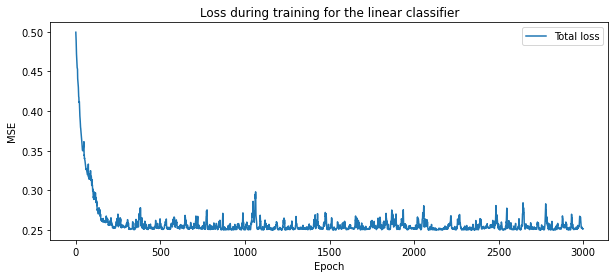

In [9]:
# Now plot the loss function
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(loss, label='Total loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Loss during training for the linear classifier')
ax.legend()
plt.plot()

## Evaluating the network

We can see above from the loss function that the network seems to have converged to something: is it good enough? Let's see what happens when we run the model on all of our data points.

In [10]:
linear_model(xor_inputs)

tensor([[0.4752],
        [0.4356],
        [0.5205],
        [0.4808]], grad_fn=<AddmmBackward0>)

We were expecting the output to be $(0, 1, 1, 0)$, so it's safe to say that this model is pretty useless. There is another way we can visualise what it's doing, which is by plotting the scalar function $\mathbb{R}^2 \to \mathbb{R}$ induced by the model as a heat map.

/home/pilex/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


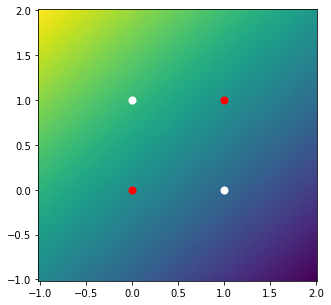

In [11]:
def make_xsys(xs, ys):
    # Given two vectors (of shape (n) and (m)), return a tensor of shape
    # (n, m, 2) such that T[i, j, :] are the (x, y) coordinates at point [i, j].
    return torch.stack(torch.meshgrid(xs, ys), dim=-1).type(torch.float)

# Make 100 equally spaced x and y points in the range [-1, 2]. Feed all the
# (x, y) pairs into the model, then convert to a Numpy array. The resulting
# tensor will have shape (n, m, 1) instead of (n, m), so squeeze the last
# coordinate away.
xs = ys = torch.linspace(-1, 2, 100)
values = linear_model(make_xsys(xs, ys)).detach().numpy()[:, :, 0]

# Plot the heatmap of the model, and an ad-hoc scatterplot of the XOR points.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(xs, ys, values)
ax.scatter(x=[0, 1], y=[0, 1], c='red', s=50)
ax.scatter(x=[0, 1], y=[1, 0], c='white', s=50)
plt.show()

## Exercise 1: Playing with tensors

We saw that the model can be run on the inputs simply with `linear_model(xor_inputs)`. For a model this simple, you should be able to extract the parameters, and evaluate the inputs yourself. Make sure you can do this. You should use some combination of `torch.matmul`, `lin`, `bias`, `xor_inputs[0, :]`, and `+`.

In [13]:
lin, bias = linear_model.parameters()
lin, bias

(Parameter containing:
 tensor([[ 0.0452, -0.0396]], requires_grad=True),
 Parameter containing:
 tensor([0.4752], requires_grad=True))

In [18]:
xor_inputs @ lin.T + bias

tensor([[0.4752],
        [0.4356],
        [0.5205],
        [0.4808]], grad_fn=<AddBackward0>)

In [19]:
linear_model(xor_inputs)

tensor([[0.4752],
        [0.4356],
        [0.5205],
        [0.4808]], grad_fn=<AddmmBackward0>)

## Attempt 2: A small  network

This time we'll use some nonlinearity! Perhaps four perceptrons, followed by a linear layer, will be enough.

**Note**: Sometimes this model converges to a good answer and sometimes it doesn't! Try re-running it.

At epoch 999, the total loss is 0.25
At epoch 1999, the total loss is 0.25
At epoch 2999, the total loss is 0.25


[]

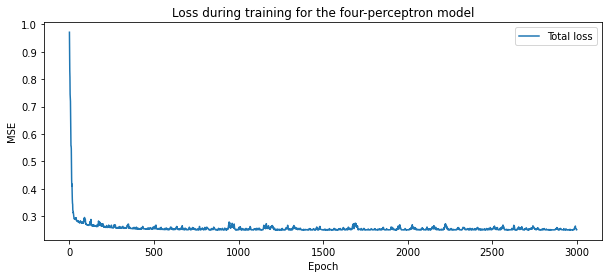

In [30]:
four_perceptron_model = nn.Sequential(
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 1),
)

loss = train_xor(four_perceptron_model, number_epochs=3000)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(loss, label='Total loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Loss during training for the four-perceptron model')
ax.legend()
plt.plot()

## Evaluating the network

The training seems to have converged: how did it do? Unlike before, the loss has converged almost to zero, which indicates a better result.

Below the results of the network on the inputs are shown to two decimal places: as you can see we get a much better result to last time.

In [27]:
(four_perceptron_model(xor_inputs) * 100).round() / 100

tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<DivBackward0>)

As we can see from the heatmap below, the neural network with four perceptrons has converged to a much better approximator of the XOR function.

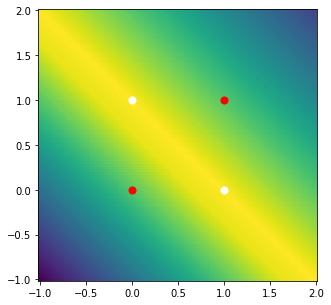

In [28]:
xs = ys = torch.linspace(-1, 2, 100)
values = four_perceptron_model(make_xsys(xs, ys)).detach().numpy()[:, :, 0]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(xs, ys, values)
ax.scatter(x=[0, 1], y=[0, 1], c='red', s=50)
ax.scatter(x=[0, 1], y=[1, 0], c='white', s=50)
plt.show()

## Exercise 2: Playing with architectures

Play around with the model, changing the number of perceptrons or the shape of the network. What is the smallest architecture that obtains good accuracy on XOR? Can you prove that it is the smallest possible?

# Task 2: Classifying annuli

In the first lecture we saw another configuration of points where a linear classifier cannot be used, when trying to tell points inside a circle from points outside of a circle.

## Generating data

Pick four numbers $r_0 < r_1 < r_2 < r_3$, then we'll generate points in the annulus of radius $[r_0, r_1]$ and call these "batch zero", and generate points in the annulus of radius $[r_2, r_3]$ and call this "batch one".

We'll generate two parallel tensors: `points` of shape $(2000, 2)$ will hold a bunch of $(x, y)$ pairs which make up the dataset, and the `categories` of shape $(2000)$ will classify them. 

For example, `points[1543, :]` will be an $(x, y)$ point, and `categories[1543]` will be $0$ if that point is in the first bucket, and $1$ if it is in the second.

We can then scatterplot this data: the `scatter` function in `matplotlib` also understands it when we pass a long vector containing categories.

In [31]:
r0, r1, r2, r3 = 0.0, 1.0, 1.1, 2.1
number = 1000

def generate_annulus(r_inner, r_outer, number=1000):
    # We generate the points using numpy, since it has better convenience functions for random distributions.
    # To get an even distribution of points on the annulus, generate points uniformly in the range
    # [r_inner^2, r_outer^2] and then square root them.
    # To convert back to a torch tensor, use torch.tensor(...).float() - the last bit at the end is because
    # PyTorch prefers float32s wheras numpy prefers float64s.
    r = np.random.uniform(low=r_inner**2, high=r_outer**2, size=number)**0.5
    theta = np.random.uniform(low=0.0, high=2*math.pi, size=number)
    return torch.tensor(np.column_stack([r * np.cos(theta), r * np.sin(theta)])).float()
  
# Generate 1000 points in the first annulus, followed by 1000 points in the second.
# Stick these together into a tensor of shape (2000, 2).
points = torch.concat([generate_annulus(r0, r1, number), generate_annulus(r2, r3, number)])

# Make a vector of 1000 zeros followed by 1000 ones: these classify the elements of the points tensor.
categories = torch.concat([torch.full(size=(number,), fill_value=0), torch.full(size=(number,), fill_value=1)])

points.shape, categories.shape

(torch.Size([2000, 2]), torch.Size([2000]))

It is always a good idea to try to plot data to make sure it is what you think it is.

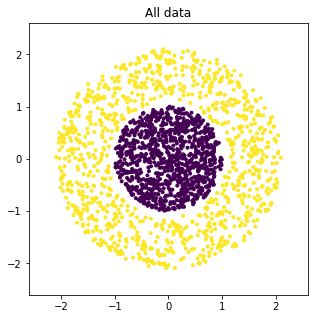

In [32]:
def setup_annuli_plot():
    fig, ax = plt.subplots(figsize=(5, 5))
    axislim = r3 + 0.5
    ax.set_xlim([-axislim, axislim])
    ax.set_ylim([-axislim, axislim])
    return ax


ax = setup_annuli_plot()
ax.scatter(x=points[:,0], y=points[:,1], c=categories, marker='.')
ax.set_title('All data')
plt.show()

## Selecting training data

First we will select a random subset of 25% of the data to be the training data.
This can be done by generating a random permutation of the integers $[0, 2000)$ and then choosing the first 500 of them. We'll plot this training data again.

In [33]:
# A vector of 500 numbers, chosen without replacement, from the range [0, 2000).
training_indices = torch.randperm(2000)[:500]

# Vectors of integers can be used to index other vectors, picking out the points
# at that index. We use this to pick out a subset of the data to use for training.
training_points = points[training_indices, :]
training_categories = categories[training_indices]

training_points.shape, training_categories.shape

(torch.Size([500, 2]), torch.Size([500]))

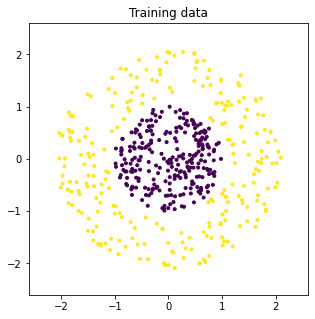

In [34]:
ax = setup_annuli_plot()
ax.scatter(x=training_points[:,0], y=training_points[:,1], c=training_categories, marker='.')
ax.set_title('Training data')
plt.show()

## Training a network

We will choose a simple network structure, consisting of five perceptrons, followed by a linear layer to the output. The output will be $\mathbb{R}^2$ this time, since we are doing classification instead of regression. A large number in the first spot indicates a classification into bucket 0, while a large number in the second spot indicates a classification into bucket 1.

Last time we were doing least-squares regression against the entire dataset: this time we will use [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) against the training subset. (Cross-entropy loss is more suited to classification, rather than regression).
A difference here that we give the `CrossEntropyLoss` function an *index* as expected output rather than another element of $\mathbb{R}^2$, for example if we expect the output to be in bucket 0, we pass `0` as the expected output rather than something like $(1.0, 0)$.

At each epoch we will randomly choose 10 points to run stochastic gradient descent on.

In [39]:
annuli_model = nn.Sequential(
    nn.Linear(2, 6),
    nn.ReLU(),
    nn.Linear(6, 2),
)

def train_annuli(model, number_epochs):
    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.01)
    training_loss = torch.zeros(number_epochs)
    total_loss = torch.zeros(number_epochs)

    for epoch in range(number_epochs):
        # Per epoch, we select a random batch of 10 elements of the training data
        # to evaluate the network on.
        batch = torch.tensor(random.sample(range(500), k=10))
        
        optimiser.zero_grad()
        model_output = model(training_points[batch])
        loss = loss_function(model_output, training_categories[batch])
        loss.backward()
        optimiser.step()
        
        # Keep track of the training and total loss of the network at each epoch.
        training_loss[epoch] = loss_function(model(training_points), training_categories)
        total_loss[epoch] = loss_function(model(points), categories)

        if epoch % 1000 == 999:
            print(f"At epoch {epoch}, the training loss is {training_loss[epoch]:.2f}, the total loss is {total_loss[epoch]:.2f}")
    
    return training_loss.detach(), total_loss.detach()

training_loss, total_loss = train_annuli(annuli_model, 8000)

At epoch 999, the training loss is 0.59, the total loss is 0.60
At epoch 1999, the training loss is 0.43, the total loss is 0.45
At epoch 2999, the training loss is 0.32, the total loss is 0.34
At epoch 3999, the training loss is 0.24, the total loss is 0.26
At epoch 4999, the training loss is 0.18, the total loss is 0.20
At epoch 5999, the training loss is 0.14, the total loss is 0.16
At epoch 6999, the training loss is 0.12, the total loss is 0.13
At epoch 7999, the training loss is 0.10, the total loss is 0.12


After 8000 steps of gradient descent, the total loss is closely matching the training loss, and dropping below $0.1$, which is a good indication that the model is training well.

The following plot of the training error shows that the training has been slowing down for the last 3000 or so iterations.

[]

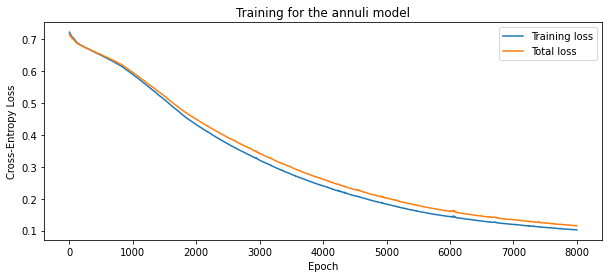

In [40]:
# Show how the loss function changed over time.
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(training_loss, label='Training loss')
ax.plot(total_loss, label='Total loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Training for the annuli model')
ax.legend()
plt.plot()

## Evaluating the network

We can see above that the cross-entropy loss is dropping. But what is the network actually doing? The cross-entropy loss function interprets the outputs of the network as probabilities using the [Softmax](https://pytorch.org/docs/stable/generated/torch.sparse.softmax.html) function: if the output weights are $(w_0, w_1)$ then the probabilities for the categories are
$$ p_0 = \frac{e^{w_0}}{e^{w_0} + e^{w_1}}, \quad p_1 = \frac{e^{w_1}}{e^{w_0} + e^{w_1}}. $$
Since the probabilities sum to 1 here, we will just plot $p_0$ for the network.

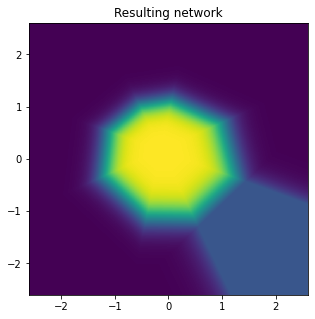

In [41]:
ax = setup_annuli_plot()
xs = torch.linspace(-r3-0.5, r3+0.5, 1000)
xsys = torch.stack(torch.meshgrid(xs, xs), dim=-1).type(torch.float)
prob0 = torch.softmax(annuli_model(xsys), dim=-1)[:, :, 0].detach().numpy()
ax.pcolormesh(xs, xs, prob0)
ax.set_title('Resulting network')
plt.show()

As we might expect, these probabilities look high inside a roughly circular region, and low outside that region. Let's see that plot again with all of the data superimposed on the top:

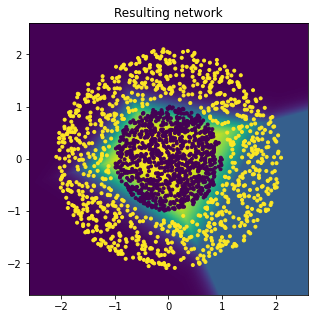

In [38]:
ax = setup_annuli_plot()
xs = torch.linspace(-r3-0.5, r3+0.5, 1000)
xsys = torch.stack(torch.meshgrid(xs, xs), dim=-1).type(torch.float)
prob0 = torch.softmax(annuli_model(xsys), dim=-1)[:, :, 0].detach().numpy()
ax.pcolormesh(xs, xs, prob0)
ax.scatter(x=points[:,0], y=points[:,1], c=categories, marker='.')
ax.set_title('Resulting network')
plt.show()

## Exercise: More playing with architectures

Mess around with the architecture of the annuli neural network. Can you see the number of perceptrons used affecting the number of hyperplanes visible in the heatmap plot?